In [28]:
import tensorflow as tf
import tensorflow_quantum as tfq
import flwr as fl

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

tf.config.run_functions_eagerly(True)

In [29]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[12000:24000]
y_train = y_train[12000:24000]
x_test = x_test[2000:4000]
y_test = y_test[2000:4000]

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 12000
Number of original test examples: 2000


In [30]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [31]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 2421
Number of filtered test examples: 401


False


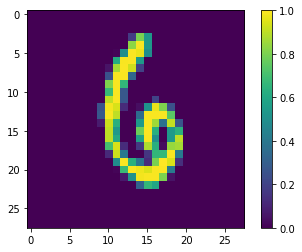

In [32]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [33]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

False


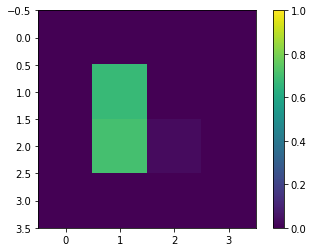

In [34]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [35]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [36]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 2207
Number of unique 3s:  1086
Number of unique 6s:  1113
Number of unique contradicting labels (both 3 and 6):  8

Initial number of images:  2421
Remaining non-contradicting unique images:  2199


In [37]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [38]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 117
Number of unique 3s:  50
Number of unique 6s:  45
Number of unique contradicting labels (both 3 and 6):  22

Initial number of images:  2199
Remaining non-contradicting unique images:  95


In [39]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

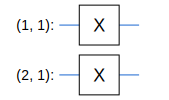

In [40]:
SVGCircuit(x_train_circ[0])

In [41]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[1, 1],
       [2, 1]])

In [42]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [43]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

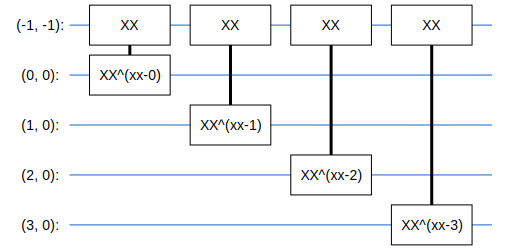

In [44]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [45]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [46]:
model_circuit, model_readout = create_quantum_model()

In [47]:
# Build the Keras model.
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(model_circuit, model_readout),
])

In [48]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [49]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [50]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [51]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [53]:
class QNN_Client(fl.client.NumPyClient):
    def get_parameters(self):
        return model.get_weights()

    def fit(self, parameters, config):
        model.set_weights(parameters)
        model.fit(
            x_train_tfcirc_sub,
            y_train_hinge_sub,
            epochs=1,
            batch_size=32,
            verbose=1,
            validation_data=(x_test_tfcirc, y_test_hinge)
        )
        return model.get_weights(), len(x_train_tfcirc_sub), {}

    def evaluate(self, parameters, config):
        model.set_weights(parameters)
        loss, accuracy = model.evaluate(x_test_tfcirc, y_test)
        return loss, len(x_test_tfcirc), {"accuracy": accuracy}

In [54]:
fl.client.start_numpy_client("[::]:8080", client=QNN_Client())

DEBUG flower 2021-12-24 17:13:28,896 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2021-12-24 17:13:28,896 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2021-12-24 17:13:28,897 | connection.py:36 | ChannelConnectivity.READY


69/69 [==============================] - 80s 1s/step - loss: 0.4657 - hinge_accuracy: 0.7914 - val_loss: 0.5375 - val_hinge_accuracy: 0.7055


DEBUG flower 2021-12-24 17:20:25,857 | connection.py:68 | Insecure gRPC channel closed
INFO flower 2021-12-24 17:20:25,857 | app.py:72 | Disconnect and shut down


In [55]:
def create_fair_classical_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 34        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [56]:
class SimpleNN_Client(fl.client.NumPyClient):
    def get_parameters(self):
        return model.get_weights()

    def fit(self, parameters, config):
        model.set_weights(parameters)
        model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=5,
          verbose=2,
          validation_data=(x_test_bin, y_test))
        return model.get_weights(), len(x_test_bin), {}

    def evaluate(self, parameters, config):
        model.set_weights(parameters)
        loss, accuracy = model.evaluate(x_test_bin, y_test)
        return loss, len(x_test_bin), {"accuracy": accuracy}

In [57]:
fl.client.start_numpy_client("[::]:8080", client=SimpleNN_Client())

DEBUG flower 2021-12-24 17:23:08,945 | connection.py:36 | ChannelConnectivity.IDLE
INFO flower 2021-12-24 17:23:08,945 | app.py:61 | Opened (insecure) gRPC connection
DEBUG flower 2021-12-24 17:23:08,946 | connection.py:36 | ChannelConnectivity.READY


Epoch 1/5
18/18 - 0s - loss: 0.7313 - accuracy: 0.5043 - val_loss: 0.7152 - val_accuracy: 0.4713
Epoch 2/5
18/18 - 0s - loss: 0.7183 - accuracy: 0.4616 - val_loss: 0.7052 - val_accuracy: 0.4863
Epoch 3/5
18/18 - 0s - loss: 0.7072 - accuracy: 0.5061 - val_loss: 0.6966 - val_accuracy: 0.5037
Epoch 4/5
18/18 - 0s - loss: 0.6980 - accuracy: 0.4857 - val_loss: 0.6900 - val_accuracy: 0.5062
Epoch 5/5
18/18 - 0s - loss: 0.6901 - accuracy: 0.4989 - val_loss: 0.6839 - val_accuracy: 0.5062
Epoch 1/5
18/18 - 0s - loss: 0.6828 - accuracy: 0.5430 - val_loss: 0.6782 - val_accuracy: 0.5411
Epoch 2/5
18/18 - 0s - loss: 0.6760 - accuracy: 0.5448 - val_loss: 0.6729 - val_accuracy: 0.5387
Epoch 3/5
18/18 - 0s - loss: 0.6693 - accuracy: 0.5684 - val_loss: 0.6678 - val_accuracy: 0.5561
Epoch 4/5
18/18 - 0s - loss: 0.6626 - accuracy: 0.5884 - val_loss: 0.6628 - val_accuracy: 0.5561
Epoch 5/5
18/18 - 0s - loss: 0.6562 - accuracy: 0.5903 - val_loss: 0.6580 - val_accuracy: 0.5561
Epoch 1/5
18/18 - 0s - loss: 0

DEBUG flower 2021-12-24 17:23:13,708 | connection.py:68 | Insecure gRPC channel closed
INFO flower 2021-12-24 17:23:13,708 | app.py:72 | Disconnect and shut down
